In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import argparse
import numpy as np
from sklearn.metrics import normalized_mutual_info_score

import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from torchvision import transforms
from torchvision.utils import make_grid
from torch.autograd import Variable

from tqdm import tqdm
import pickle
from torch import optim

In [2]:
class Encoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(Encoder, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc1_bn=nn.BatchNorm1d(h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc2_bn=nn.BatchNorm1d(h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        
        self.x_dim = x_dim
        
    def encoder(self, x):
        h = F.relu(self.fc1_bn(self.fc1(x)))
        h = F.relu(self.fc2_bn(self.fc2(h)))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5*log_var)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu) # return z sample
        else:
            return mu
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, self.x_dim))
        z = self.sampling(mu, log_var)
        return z, mu, log_var

class Decoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(Decoder, self).__init__()
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc4_bn =nn.BatchNorm1d(h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc5_bn =nn.BatchNorm1d(h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
        self.x_dim = x_dim
        
    def decoder(self, z):
        h = F.relu(self.fc4_bn(self.fc4(z)))
        h = F.relu(self.fc5_bn(self.fc5(h)))
        return F.tanh(self.fc6(h)) 
    
    def forward(self, z):
        return self.decoder(z)


In [3]:
from torch.utils.data import Dataset

class AttributeDataset(Dataset):
    def __init__(self, root, split, transform=None):
        super(AttributeDataset, self).__init__()
        data_path = os.path.join(root, split, "images.npy")
        self.data = np.load(data_path)
        
        attr_path = os.path.join(root, split, "attrs.npy")
        self.attr = torch.LongTensor(np.load(attr_path))

        attr_names_path = os.path.join(root, "attr_names.pkl")
        with open(attr_names_path, "rb") as f:
            self.attr_names = pickle.load(f)
        
        self.num_attrs =  self.attr.size(1)
        self.transform = transform
        
    def __len__(self):
        return self.attr.size(0)

    def __getitem__(self, index):
        image, digit, color = self.data[index], self.attr[index, 0], self.attr[index, 1]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, digit, color

In [4]:
data_dir='./data/ColoredMNIST-Skewed0.3-Severity1'
# data_dir='./data/ColoredMNIST-Skewed0.05-Severity4/'
split = 'train'

In [5]:
MEAN = torch.tensor([0.5,0.5,0.5])
STD = torch.tensor([0.5,0.5,0.5])

batch_size = 256

train_set = AttributeDataset(data_dir, split, transform=transforms.Compose([transforms.ToTensor(),
                                                                           transforms.Normalize(MEAN, STD)]))
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
train_loader_2 = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

test_set = AttributeDataset(data_dir, 'valid', transform=transforms.Compose([transforms.ToTensor(),
                                                                           transforms.Normalize(MEAN, STD)]))

import torch
seed = 2020
torch.manual_seed(seed) 
def worker_init_fn(worker_id):
    torch.manual_seed(seed + worker_id)
    
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=128, shuffle=True, worker_init_fn=worker_init_fn)
img_test, label_test, color_test = next(iter(test_loader))
img_test, label_test, color_test = img_test.cuda(), label_test.cuda(), color_test.cuda()

In [6]:
for i in range(10):
    digit_idx = train_set.attr[:, 0] == i
    print((train_set.attr[digit_idx, 1] == 3).float().mean())

tensor(0.0333)
tensor(0.0334)
tensor(0.0332)
tensor(0.7000)
tensor(0.0334)
tensor(0.0334)
tensor(0.0333)
tensor(0.0332)
tensor(0.0333)
tensor(0.0333)


In [7]:
class Classifier(nn.Module):
    def __init__(self, input_dim = 64, hidden_dim = 16, output_dim = 2):
        super(Classifier, self).__init__()
        self.input_dim = input_dim 
        self.dense1 = nn.Linear(input_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = self.dense2(x)
        
        return x
    def get_parameters(self):
        return [{"params": self.parameters(), "lr_mult": 1}]

In [8]:
def compute_density(z, mu, logvar, marginal = True):
    pi = Variable(torch.Tensor([np.log(2 * np.pi)])).type_as(z)
    inv_sigma = torch.exp(-logvar)
    tmp = (z - mu) * inv_sigma
    # return (-0.5 * (tmp * tmp + 2 * logvar + pi)).exp().prod(-1, keepdim = True)
    value = (-0.5 * (tmp * tmp + 2 * logvar + pi)).sum(-1).exp()
    
    if marginal:
        return value.mean(-1)
    else:
        return value
    
def expand_latent(x,y,z = None):
    if z is None:
        x_expand = x.unsqueeze(1).expand(-1, x.shape[0], -1)
        y_expand = y.unsqueeze(0).expand(x.shape[0], -1, -1)
        return x_expand, y_expand
    else:
        x_expand = x.unsqueeze(1).expand(-1, x.shape[0], -1)
        y_expand = y.unsqueeze(1).expand(-1, x.shape[0], -1)
        z_expand = z.unsqueeze(0).expand(x.shape[0], -1, -1)
        return x_expand, y_expand, z_expand

In [9]:
def CMI_loss(cls, z_y, z_r, s_batch, num_group = 10, beta=0.5):
    # updated 10/16/2023
    # updated H(Y|A,z_r) computation.
    z_y_repeat, z_r_repeat = expand_latent(z_y,z_r)

    z_yr = torch.cat([z_y_repeat, z_r_repeat], dim = -1).view(z_y.shape[0] **2, -1)

    p_y = torch.softmax(cls_y(z_yr).view(z_y.shape[0], z_y.shape[0], -1), -1)
    p_y_agg = p_y.mean(0)

    H_y_cond_z = -(p_y_agg * torch.log(p_y_agg + 1e-7)).sum(-1).mean()

    H_y_cond_za = 0.
    for idx in range(num_group): 
        s_idx = s_batch.view(-1) == idx

        p_y_zra = p_y[s_idx, :][:, s_idx, :].mean(0)
        H_y_cond_za += (- p_y_zra * torch.log(p_y_zra + 1e-7)).sum()
    H_y_cond_za /= s_batch.shape[0]  
    I_y_az = (1-beta) * H_y_cond_z - H_y_cond_za
    
    return I_y_az

In [10]:
def permute_zs(zs):
    B, _ = zs[0].size()
    perm_z = []
    
    for z_i in zs:
        perm = torch.randperm(B).cuda()
        perm_z.append(z_i[perm])
    return torch.cat(perm_z, 1)

## 1. Training FADES model

====> Epoch: 0, ELBO: 281.267, Fair Loss : -5.562, D_loss : 0.674, Y Loss: 0.338,  A Loss: 0.518


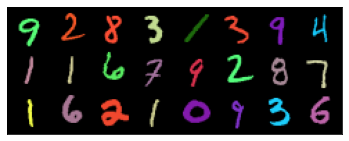

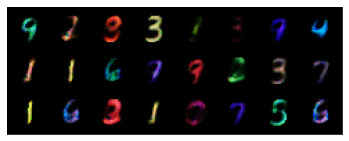

====> Epoch: 1, ELBO: 239.740, Fair Loss : -4.062, D_loss : 0.670, Y Loss: 0.236,  A Loss: 0.318
====> Epoch: 2, ELBO: 211.148, Fair Loss : -3.031, D_loss : 0.682, Y Loss: 0.155,  A Loss: 0.172
====> Epoch: 3, ELBO: 224.162, Fair Loss : -3.098, D_loss : 0.692, Y Loss: 0.076,  A Loss: 0.176
====> Epoch: 4, ELBO: 208.066, Fair Loss : -4.262, D_loss : 0.698, Y Loss: 0.101,  A Loss: 0.156
====> Epoch: 5, ELBO: 197.459, Fair Loss : -3.048, D_loss : 0.701, Y Loss: 0.094,  A Loss: 0.120
====> Epoch: 6, ELBO: 193.290, Fair Loss : -2.898, D_loss : 0.700, Y Loss: 0.028,  A Loss: 0.167
====> Epoch: 7, ELBO: 179.667, Fair Loss : -2.187, D_loss : 0.713, Y Loss: 0.037,  A Loss: 0.084
====> Epoch: 8, ELBO: 197.043, Fair Loss : -3.891, D_loss : 0.692, Y Loss: 0.054,  A Loss: 0.084
====> Epoch: 9, ELBO: 198.366, Fair Loss : -2.712, D_loss : 0.711, Y Loss: 0.117,  A Loss: 0.093
====> Epoch: 10, ELBO: 201.349, Fair Loss : -2.644, D_loss : 0.706, Y Loss: 0.115,  A Loss: 0.088


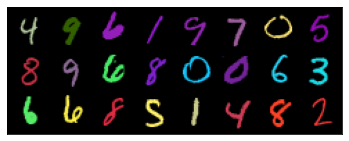

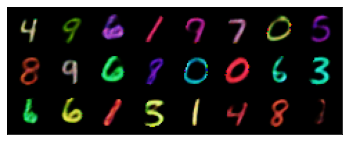

====> Epoch: 11, ELBO: 204.059, Fair Loss : -3.180, D_loss : 0.704, Y Loss: 0.064,  A Loss: 0.034
====> Epoch: 12, ELBO: 175.585, Fair Loss : -3.036, D_loss : 0.721, Y Loss: 0.054,  A Loss: 0.034
====> Epoch: 13, ELBO: 168.114, Fair Loss : -3.128, D_loss : 0.725, Y Loss: 0.043,  A Loss: 0.043
====> Epoch: 14, ELBO: 169.744, Fair Loss : -1.953, D_loss : 0.722, Y Loss: 0.041,  A Loss: 0.030
====> Epoch: 15, ELBO: 177.029, Fair Loss : -2.484, D_loss : 0.734, Y Loss: 0.022,  A Loss: 0.025
====> Epoch: 16, ELBO: 168.969, Fair Loss : -3.189, D_loss : 0.726, Y Loss: 0.011,  A Loss: 0.035
====> Epoch: 17, ELBO: 165.772, Fair Loss : -3.712, D_loss : 0.715, Y Loss: 0.026,  A Loss: 0.025
====> Epoch: 18, ELBO: 173.187, Fair Loss : -2.302, D_loss : 0.732, Y Loss: 0.018,  A Loss: 0.052
====> Epoch: 19, ELBO: 188.173, Fair Loss : -3.296, D_loss : 0.714, Y Loss: 0.054,  A Loss: 0.026
====> Epoch: 20, ELBO: 162.922, Fair Loss : -2.869, D_loss : 0.740, Y Loss: 0.020,  A Loss: 0.042


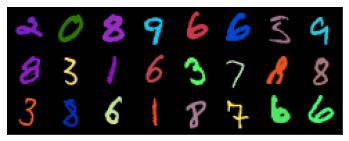

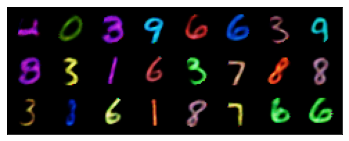

====> Epoch: 21, ELBO: 183.070, Fair Loss : -2.357, D_loss : 0.748, Y Loss: 0.012,  A Loss: 0.040
====> Epoch: 22, ELBO: 168.695, Fair Loss : -2.353, D_loss : 0.760, Y Loss: 0.042,  A Loss: 0.044
====> Epoch: 23, ELBO: 166.655, Fair Loss : -2.702, D_loss : 0.757, Y Loss: 0.005,  A Loss: 0.038
====> Epoch: 24, ELBO: 166.358, Fair Loss : -2.591, D_loss : 0.758, Y Loss: 0.023,  A Loss: 0.084
====> Epoch: 25, ELBO: 165.495, Fair Loss : -2.403, D_loss : 0.734, Y Loss: 0.013,  A Loss: 0.141
====> Epoch: 26, ELBO: 177.605, Fair Loss : -3.687, D_loss : 0.728, Y Loss: 0.048,  A Loss: 0.030
====> Epoch: 27, ELBO: 172.989, Fair Loss : -3.041, D_loss : 0.735, Y Loss: 0.017,  A Loss: 0.025
====> Epoch: 28, ELBO: 159.176, Fair Loss : -2.589, D_loss : 0.773, Y Loss: 0.038,  A Loss: 0.019
====> Epoch: 29, ELBO: 169.071, Fair Loss : -2.152, D_loss : 0.761, Y Loss: 0.040,  A Loss: 0.003
====> Epoch: 30, ELBO: 169.638, Fair Loss : -2.682, D_loss : 0.763, Y Loss: 0.006,  A Loss: 0.008


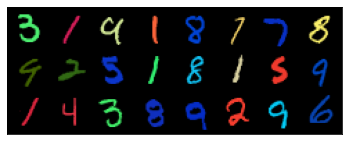

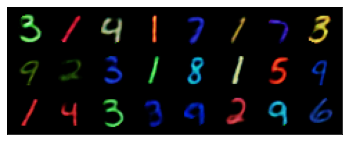

====> Epoch: 31, ELBO: 182.077, Fair Loss : -3.211, D_loss : 0.743, Y Loss: 0.068,  A Loss: 0.027
====> Epoch: 32, ELBO: 172.789, Fair Loss : -2.873, D_loss : 0.753, Y Loss: 0.017,  A Loss: 0.024
====> Epoch: 33, ELBO: 170.271, Fair Loss : -3.000, D_loss : 0.764, Y Loss: 0.108,  A Loss: 0.064
====> Epoch: 34, ELBO: 173.929, Fair Loss : -4.167, D_loss : 0.760, Y Loss: 0.086,  A Loss: 0.010
====> Epoch: 35, ELBO: 155.205, Fair Loss : -2.683, D_loss : 0.757, Y Loss: 0.041,  A Loss: 0.018
====> Epoch: 36, ELBO: 166.243, Fair Loss : -2.472, D_loss : 0.743, Y Loss: 0.014,  A Loss: 0.082
====> Epoch: 37, ELBO: 165.519, Fair Loss : -3.236, D_loss : 0.774, Y Loss: 0.004,  A Loss: 0.009
====> Epoch: 38, ELBO: 164.024, Fair Loss : -3.115, D_loss : 0.759, Y Loss: 0.025,  A Loss: 0.064
====> Epoch: 39, ELBO: 158.759, Fair Loss : -3.181, D_loss : 0.765, Y Loss: 0.009,  A Loss: 0.007
====> Epoch: 40, ELBO: 171.242, Fair Loss : -2.433, D_loss : 0.768, Y Loss: 0.050,  A Loss: 0.007


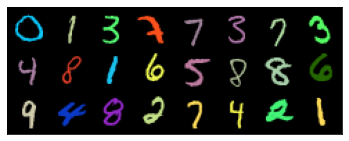

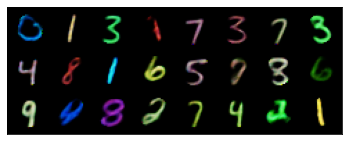

====> Epoch: 41, ELBO: 166.153, Fair Loss : -2.763, D_loss : 0.750, Y Loss: 0.004,  A Loss: 0.042
====> Epoch: 42, ELBO: 159.585, Fair Loss : -2.729, D_loss : 0.778, Y Loss: 0.012,  A Loss: 0.010
====> Epoch: 43, ELBO: 163.716, Fair Loss : -3.161, D_loss : 0.787, Y Loss: 0.019,  A Loss: 0.012
====> Epoch: 44, ELBO: 177.388, Fair Loss : -2.316, D_loss : 0.757, Y Loss: 0.135,  A Loss: 0.009
====> Epoch: 45, ELBO: 151.488, Fair Loss : -2.660, D_loss : 0.810, Y Loss: 0.008,  A Loss: 0.025
====> Epoch: 46, ELBO: 154.105, Fair Loss : -2.545, D_loss : 0.781, Y Loss: 0.002,  A Loss: 0.014
====> Epoch: 47, ELBO: 153.542, Fair Loss : -1.535, D_loss : 0.820, Y Loss: 0.005,  A Loss: 0.025
====> Epoch: 48, ELBO: 159.309, Fair Loss : -2.247, D_loss : 0.777, Y Loss: 0.011,  A Loss: 0.041
====> Epoch: 49, ELBO: 168.093, Fair Loss : -3.097, D_loss : 0.746, Y Loss: 0.005,  A Loss: 0.033
====> Epoch: 50, ELBO: 161.748, Fair Loss : -2.968, D_loss : 0.765, Y Loss: 0.048,  A Loss: 0.009


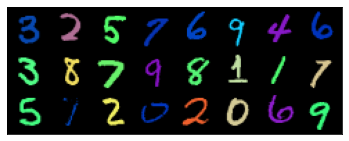

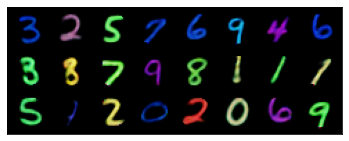

====> Epoch: 51, ELBO: 160.664, Fair Loss : -3.540, D_loss : 0.781, Y Loss: 0.012,  A Loss: 0.015
====> Epoch: 52, ELBO: 156.981, Fair Loss : -3.712, D_loss : 0.762, Y Loss: 0.206,  A Loss: 0.041
====> Epoch: 53, ELBO: 151.800, Fair Loss : -2.764, D_loss : 0.801, Y Loss: 0.005,  A Loss: 0.015
====> Epoch: 54, ELBO: 157.425, Fair Loss : -3.025, D_loss : 0.790, Y Loss: 0.031,  A Loss: 0.018
====> Epoch: 55, ELBO: 171.470, Fair Loss : -3.341, D_loss : 0.770, Y Loss: 0.028,  A Loss: 0.008
====> Epoch: 56, ELBO: 173.467, Fair Loss : -2.789, D_loss : 0.803, Y Loss: 0.086,  A Loss: 0.032
====> Epoch: 57, ELBO: 143.498, Fair Loss : -2.611, D_loss : 0.846, Y Loss: 0.003,  A Loss: 0.011
====> Epoch: 58, ELBO: 163.645, Fair Loss : -3.542, D_loss : 0.797, Y Loss: 0.007,  A Loss: 0.066
====> Epoch: 59, ELBO: 159.713, Fair Loss : -2.298, D_loss : 0.787, Y Loss: 0.009,  A Loss: 0.002
====> Epoch: 60, ELBO: 150.390, Fair Loss : -2.488, D_loss : 0.790, Y Loss: 0.019,  A Loss: 0.046


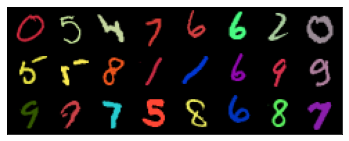

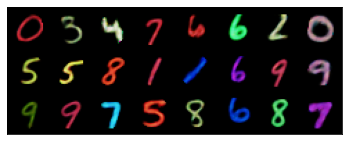

====> Epoch: 61, ELBO: 151.119, Fair Loss : -3.242, D_loss : 0.787, Y Loss: 0.010,  A Loss: 0.015
====> Epoch: 62, ELBO: 161.906, Fair Loss : -2.409, D_loss : 0.772, Y Loss: 0.010,  A Loss: 0.017
====> Epoch: 63, ELBO: 156.313, Fair Loss : -3.144, D_loss : 0.764, Y Loss: 0.008,  A Loss: 0.017
====> Epoch: 64, ELBO: 158.937, Fair Loss : -2.227, D_loss : 0.815, Y Loss: 0.035,  A Loss: 0.098
====> Epoch: 65, ELBO: 147.888, Fair Loss : -3.639, D_loss : 0.795, Y Loss: 0.030,  A Loss: 0.004
====> Epoch: 66, ELBO: 152.887, Fair Loss : -3.436, D_loss : 0.824, Y Loss: 0.038,  A Loss: 0.040
====> Epoch: 67, ELBO: 160.037, Fair Loss : -3.348, D_loss : 0.796, Y Loss: 0.025,  A Loss: 0.037
====> Epoch: 68, ELBO: 174.265, Fair Loss : -3.013, D_loss : 0.781, Y Loss: 0.004,  A Loss: 0.059
====> Epoch: 69, ELBO: 151.824, Fair Loss : -3.162, D_loss : 0.817, Y Loss: 0.005,  A Loss: 0.008
====> Epoch: 70, ELBO: 166.482, Fair Loss : -3.008, D_loss : 0.768, Y Loss: 0.021,  A Loss: 0.208


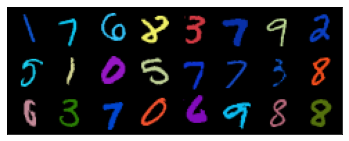

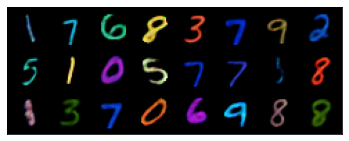

====> Epoch: 71, ELBO: 163.890, Fair Loss : -3.074, D_loss : 0.810, Y Loss: 0.003,  A Loss: 0.038
====> Epoch: 72, ELBO: 155.521, Fair Loss : -4.358, D_loss : 0.786, Y Loss: 0.002,  A Loss: 0.004
====> Epoch: 73, ELBO: 162.888, Fair Loss : -1.780, D_loss : 0.820, Y Loss: 0.009,  A Loss: 0.025
====> Epoch: 74, ELBO: 149.368, Fair Loss : -3.399, D_loss : 0.799, Y Loss: 0.040,  A Loss: 0.003
====> Epoch: 75, ELBO: 163.760, Fair Loss : -2.084, D_loss : 0.809, Y Loss: 0.072,  A Loss: 0.040
====> Epoch: 76, ELBO: 158.325, Fair Loss : -4.016, D_loss : 0.776, Y Loss: 0.006,  A Loss: 0.052
====> Epoch: 77, ELBO: 165.268, Fair Loss : -3.825, D_loss : 0.790, Y Loss: 0.056,  A Loss: 0.020
====> Epoch: 78, ELBO: 154.663, Fair Loss : -3.656, D_loss : 0.815, Y Loss: 0.020,  A Loss: 0.003
====> Epoch: 79, ELBO: 163.119, Fair Loss : -2.944, D_loss : 0.806, Y Loss: 0.007,  A Loss: 0.004
====> Epoch: 80, ELBO: 153.715, Fair Loss : -3.799, D_loss : 0.778, Y Loss: 0.016,  A Loss: 0.007


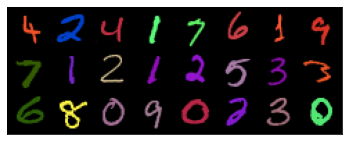

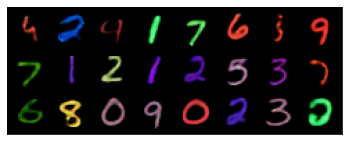

====> Epoch: 81, ELBO: 155.390, Fair Loss : -3.153, D_loss : 0.776, Y Loss: 0.008,  A Loss: 0.043
====> Epoch: 82, ELBO: 151.065, Fair Loss : -3.615, D_loss : 0.774, Y Loss: 0.002,  A Loss: 0.021
====> Epoch: 83, ELBO: 158.912, Fair Loss : -5.015, D_loss : 0.763, Y Loss: 0.006,  A Loss: 0.041
====> Epoch: 84, ELBO: 153.850, Fair Loss : -3.086, D_loss : 0.821, Y Loss: 0.220,  A Loss: 0.006
====> Epoch: 85, ELBO: 162.601, Fair Loss : -3.002, D_loss : 0.805, Y Loss: 0.014,  A Loss: 0.011
====> Epoch: 86, ELBO: 147.049, Fair Loss : -2.221, D_loss : 0.819, Y Loss: 0.015,  A Loss: 0.010
====> Epoch: 87, ELBO: 144.848, Fair Loss : -2.901, D_loss : 0.792, Y Loss: 0.006,  A Loss: 0.030
====> Epoch: 88, ELBO: 146.146, Fair Loss : -3.656, D_loss : 0.813, Y Loss: 0.002,  A Loss: 0.009
====> Epoch: 89, ELBO: 154.019, Fair Loss : -3.229, D_loss : 0.822, Y Loss: 0.002,  A Loss: 0.003
====> Epoch: 90, ELBO: 142.735, Fair Loss : -3.393, D_loss : 0.782, Y Loss: 0.004,  A Loss: 0.071


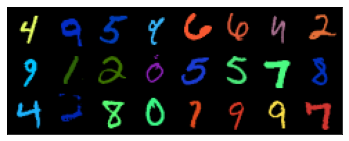

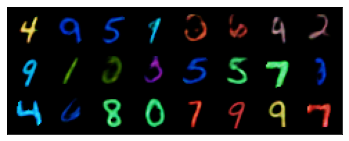

====> Epoch: 91, ELBO: 152.052, Fair Loss : -3.800, D_loss : 0.769, Y Loss: 0.041,  A Loss: 0.003
====> Epoch: 92, ELBO: 152.368, Fair Loss : -3.283, D_loss : 0.782, Y Loss: 0.004,  A Loss: 0.008
====> Epoch: 93, ELBO: 180.142, Fair Loss : -2.222, D_loss : 0.794, Y Loss: 0.131,  A Loss: 0.011
====> Epoch: 94, ELBO: 155.766, Fair Loss : -3.925, D_loss : 0.781, Y Loss: 0.014,  A Loss: 0.147
====> Epoch: 95, ELBO: 155.104, Fair Loss : -3.239, D_loss : 0.834, Y Loss: 0.006,  A Loss: 0.012
====> Epoch: 96, ELBO: 162.473, Fair Loss : -3.067, D_loss : 0.800, Y Loss: 0.009,  A Loss: 0.008
====> Epoch: 97, ELBO: 152.538, Fair Loss : -4.014, D_loss : 0.779, Y Loss: 0.005,  A Loss: 0.029
====> Epoch: 98, ELBO: 146.021, Fair Loss : -2.941, D_loss : 0.808, Y Loss: 0.008,  A Loss: 0.055
====> Epoch: 99, ELBO: 158.110, Fair Loss : -2.715, D_loss : 0.834, Y Loss: 0.014,  A Loss: 0.007
====> Epoch: 100, ELBO: 145.783, Fair Loss : -3.240, D_loss : 0.821, Y Loss: 0.029,  A Loss: 0.006


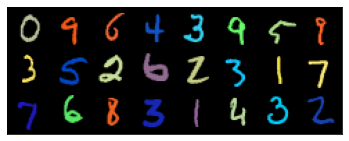

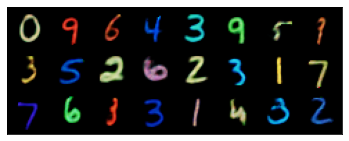

In [11]:
criterion = nn.CrossEntropyLoss()

cls_y = Classifier(input_dim = 4, output_dim = 10).cuda()
cls_a = Classifier(input_dim = 4, output_dim = 10).cuda()
dis = Classifier(input_dim = 6, output_dim = 1).cuda()

encoder = Encoder(x_dim=3*28*28, h_dim1= 256, h_dim2=256, z_dim=8).cuda()
decoder = Decoder(x_dim=3*28*28, h_dim1= 256, h_dim2=256, z_dim=8).cuda()

param_lst = list()
param_lst += list(encoder.parameters()) + list(decoder.parameters())
param_lst += list(cls_y.parameters()) + list(cls_a.parameters())         

optimizer = optim.Adam(param_lst, lr = 1e-3, weight_decay = 1e-5)
optimizer_d = optim.Adam(dis.parameters(), lr = 1e-4, weight_decay = 1e-5)

lambda_fair = 1e1
lambda_tc = 1e1

for epoch in range(100+1):
    train_loss = 0
    acc_y, acc_a, acc_y_pert = [], [], []
    train_iter = iter(train_loader_2)
    
    for batch_idx, (data, digit, color) in enumerate(train_loader):
        data = data.cuda()
        digit, color = digit.cuda(), color.cuda()

        optimizer.zero_grad()
        z, mu, log_var = encoder(data)
        z_y, z_r, z_a, z_x = z.split(2, dim = -1)
        mu_y, mu_r, mu_a, mu_x = mu.split(2, dim = -1)
        logvar_y, logvar_r, logvar_a, logvar_x = log_var.split(2, dim = -1)
        
        recon = decoder(z)

        MSE = F.l1_loss(recon, data.view(-1, 3*28*28), reduction = 'sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        ELBO = MSE + KLD
        ELBO /= len(data)

        pred_y = cls_y(torch.cat([z_y, z_r], dim =-1))
        pred_a = cls_a(torch.cat([z_a, z_r], dim =-1))

        loss_cls_y = criterion(pred_y, digit)
        loss_cls_a = criterion(pred_a, color)
        loss_cls = loss_cls_y + 0.5 * loss_cls_a 

        acc_a.append(pred_a.argmax(-1) == color)
        acc_y.append(pred_y.argmax(-1) == digit)

        loss = ELBO + 1e2 * loss_cls
        
        a_hat = pred_a.argmax(-1).detach()
        y_hat = pred_y.argmax(-1).detach()
        
        loss_fair = 0.5 * (CMI_loss(cls_y, z_y, z_r, color) + CMI_loss(cls_a, z_a, z_r, digit))
        loss_fair = lambda_fair * loss_fair
        loss += loss_fair
        
        
        ## Discriminator 
        pred_d = torch.sigmoid(dis(torch.cat([z_y, z_r, z_a],dim =1)))
        loss_D = -torch.log(pred_d+ 1e-7).mean()
        
        loss += lambda_tc * loss_D

        loss.backward()
        
        train_loss += loss.item()
        
        optimizer.step()
        
        x_batch_2, _, _ = next(train_iter)
        x_batch_2 = x_batch_2.cuda().float()
        z_2, _, _ = encoder(x_batch_2)
        z_y_2, z_r_2, z_a_2, _ = z_2.split(2, dim = -1) # [z_x, z_y, z_r, z_a]

        pred_d_2_perm = permute_zs([z_y_2, z_r_2, z_a_2])
        pred_d_2 = torch.sigmoid(dis(pred_d_2_perm))

        z, mu, logvar = encoder(data)
        z_y, z_r, z_a, z_x = z.split(2, dim = -1)
        pred_d = torch.sigmoid(dis(torch.cat([z_y, z_r, z_a], dim =1)))

        D_tc_loss = 0.5 * (-torch.log(1-pred_d + 1e-7) \
                               - torch.log(pred_d_2 + 1e-7)).mean()

        optimizer_d.zero_grad()
        D_tc_loss.backward()
        optimizer_d.step()

    acc_a = torch.cat(acc_a, dim = 0).float().mean()
    acc_y = torch.cat(acc_y, dim = 0).float().mean()

    print('====> Epoch: {}, ELBO: {:.3f}, Fair Loss : {:.3f}, D_loss : {:.3f}, Y Loss: {:.3f},  A Loss: {:.3f}'\
                  .format(epoch, ELBO.item(), loss_fair.item(), loss_D.item(), loss_cls_y.item(), loss_cls_a.item() ))
    
    if epoch%10 == 0:
        with torch.no_grad():
            img, label, color = next(iter(test_loader))
            z, mu, var = encoder(img.cuda())
            recon = decoder(z)

            img = img[:24].cpu() * STD[:, None, None] + MEAN[:, None, None]
            fig = plt.imshow(make_grid(img, ncol=1).permute(1,2,0))
            plt.xticks([])
            plt.yticks([])
            plt.show()

            recon = recon.view(-1, 3, 28, 28)[:24].cpu() * STD[:, None, None] + MEAN[:, None, None]
            fig = plt.imshow(make_grid(recon, ncol=1).permute(1,2,0))
            plt.xticks([])
            plt.yticks([])
            plt.show()

In [12]:
torch.save({'state_dict':encoder.state_dict()}, './save/fades_encoder.pth')
torch.save({'state_dict':decoder.state_dict()}, './save/fades_decoder.pth')


## 2. Test Set t-SNE

In [13]:
encoder = Encoder(x_dim=3*28*28, h_dim1= 256, h_dim2=256, z_dim=8).cuda()
decoder = Decoder(x_dim=3*28*28, h_dim1= 256, h_dim2=256, z_dim=8).cuda()
encoder.load_state_dict(torch.load('./save/fades_encoder.pth')['state_dict'])
decoder.load_state_dict(torch.load('./save/fades_decoder.pth')['state_dict'])

encoder.eval();
decoder.eval();

In [14]:
latents_test = list()
labels_test = list()
colors_test = list()

encoder.eval()
with torch.no_grad():
    for img, label, color in test_loader:
        _, mu, var = encoder(img.cuda())
        latents_test.append(mu)
        labels_test.append(label)
        colors_test.append(color)

latents_test = torch.cat(latents_test, dim = 0)
labels_test = torch.cat(labels_test, dim = 0)
colors_test = torch.cat(colors_test, dim = 0)

In [15]:
tsne_test =  TSNE(n_components=2).fit_transform(latents_test.detach().cpu().numpy()[:, :4])

/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/tmp/ipykernel_3004676/224621295.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c = labels_test.numpy(), s = 1, cmap=plt.cm.get_cmap("jet"))


([], [])

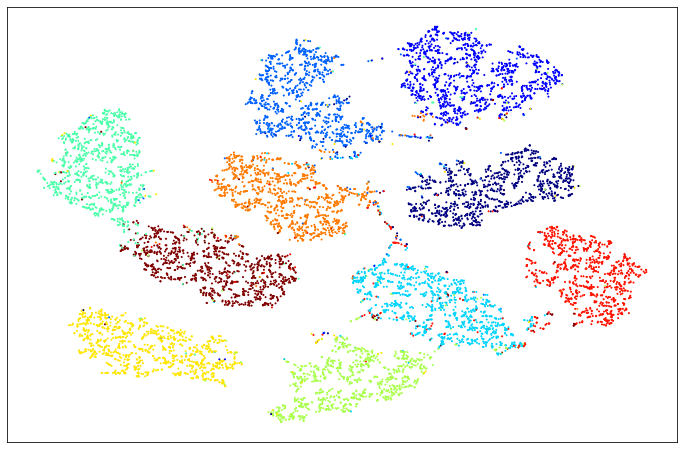

In [16]:
plt.figure(figsize = (12,8))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c = labels_test.numpy(), s = 1, cmap=plt.cm.get_cmap("jet"))
plt.xticks([])
plt.yticks([])


/tmp/ipykernel_3004676/2501821555.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c = colors_test.numpy(), s = 1, cmap=plt.cm.get_cmap("jet"))


([], [])

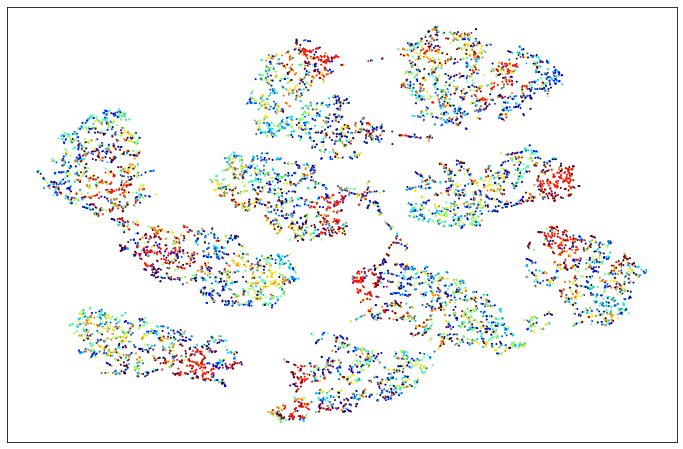

In [17]:
plt.figure(figsize = (12,8))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c = colors_test.numpy(), s = 1, cmap=plt.cm.get_cmap("jet"))
plt.xticks([])
plt.yticks([])



## 3. Reconstruction

#### Load trained model

In [ ]:
# encoder = Encoder(x_dim=3*28*28, h_dim1= 256, h_dim2=256, z_dim=16).cuda()
# decoder = Decoder(x_dim=3*28*28, h_dim1= 256, h_dim2=256, z_dim=16).cuda()
# encoder.load_state_dict(torch.load('./save/c-mnist/CVPR24_encoder_fades.pth')['state_dict'])
# decoder.load_state_dict(torch.load('./save/c-mnist/CVPR24_decoder_fades.pth')['state_dict'])

# encoder.eval();
# decoder.eval();

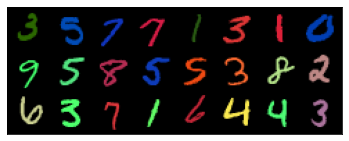

In [18]:
img = img_test[:24].cpu() * STD[:, None, None] + MEAN[:, None, None]
plt.imshow(make_grid(img, ncol=1).permute(1,2,0))
plt.xticks([])
plt.yticks([])
# plt.savefig('figure/c-mnist/original.pdf', bbox_inches = 'tight')
plt.show()

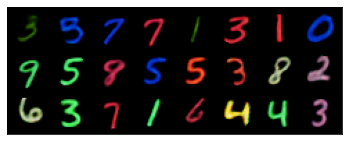

In [19]:
z, mu, _ = encoder(img_test.cuda())
recon = decoder(mu)

with torch.no_grad():
    recon = recon.view(-1, 3, 28, 28)[:24].cpu() * STD[:, None, None] + MEAN[:, None, None]
    plt.imshow(make_grid(recon, ncol=1).permute(1,2,0))
    plt.xticks([])
    plt.yticks([])
#     plt.show()
#     plt.savefig('figure/c-mnist/recon_fades.pdf', bbox_inches = 'tight')


## 4. Qualitative measure in Table 2

#### Oracle classifiers

Load orcale classifiers to quantitatively measure the quality of reconstruction.

In [20]:
class Classifier_oracle(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, n_class):
        super(Classifier_oracle, self).__init__()
        self.x_dim = x_dim
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc1_bn=nn.BatchNorm1d(h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc2_bn=nn.BatchNorm1d(h_dim2)
        self.fc3 = nn.Linear(h_dim2, n_class)
        
    def forward(self, x):
        h = F.relu(self.fc1_bn(self.fc1(x.view(-1, self.x_dim))))
        h = F.relu(self.fc2_bn(self.fc2(h)))
        return self.fc3(h)


In [21]:
cls_ocl_y = Classifier_oracle(x_dim=3*28*28, h_dim1= 256, h_dim2=256, n_class=10).cuda()
cls_ocl_a = Classifier_oracle(x_dim=3*28*28, h_dim1= 256, h_dim2=256, n_class=10).cuda()

cls_ocl_y.load_state_dict(torch.load('save/cls_digit.pth')['state_dict'])
cls_ocl_a.load_state_dict(torch.load('save/cls_color.pth')['state_dict'])


<All keys matched successfully>

In [22]:
with torch.no_grad():
    pred_y_lst, pred_a_lst, y_lst, a_lst = [], [], [], []

    for img, label, color in test_loader:
        z, _, _ = encoder(img.cuda())
        img = decoder(z)
        pred_y = cls_ocl_y(img)
        pred_a = cls_ocl_a(img)


        y_lst.append(label.detach())
        a_lst.append(color.detach())
        pred_y_lst.append(pred_y.argmax(-1).detach().cpu())
        pred_a_lst.append(pred_a.argmax(-1).detach().cpu())

    y_lst = torch.cat(y_lst, dim = 0)
    a_lst = torch.cat(a_lst, dim = 0)
    pred_y_lst = torch.cat(pred_y_lst, dim = 0)
    pred_a_lst = torch.cat(pred_a_lst, dim = 0)
    
print((pred_y_lst == y_lst).float().mean())
print((pred_a_lst == a_lst).float().mean())

tensor(0.9304)
tensor(0.9618)
